# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Project Milestone 3:  Model building

In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style='height:2pt'>
<div class='theme'> Discrimination Analysis </div> 

**To investigate whether there exists discrimination in LandingClub, we simplify our question as: whether applicants from a certain state were less likely to receive a loan.    
One way we think about this question is that for a given state if the rejection rate is higher than the proportion of loans of that state among total loans, then that state is likely to be underprivileged.     
The other way is that there should be a postive associate between the acceptance rate and the probability of fully paid. So we want to use data of 50 states to fit a linear regression model, the states under the trend line are likely to be underprivileged while those above the trend line should be considered as being privileged.**

In [236]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [24]:
acc_data = pd.read_csv('cdf_acc2016.csv')
acc_data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,35000,35000,60,21.18,950.42,E,10+,MORTGAGE,195000.0,1,Mar-2016,1,debt_consolidation,871xx,NM,15.56,0,Aug-2004,0,9,0,32223,0.934,28,w,0.0,0.0,47748.356466,47748.36,35000.0,12748.36,Mar-2018,26612.62,Jul-2018,Individual,0,0,644712.0,34500,12,71635,878,91.2,0,0,122,95,7,7,4,15,1,1,4,1,2,17,4,7,4,9,0,0,0,4,88.5,100.0,0,0,671522,166084,10000,138709,N,Cash,N
1,16000,16000,36,5.32,481.84,A,8,RENT,105000.0,0,Mar-2016,1,debt_consolidation,206xx,MD,15.02,1,Nov-2000,0,9,0,6219,0.279,21,w,0.0,0.0,16098.340000,16098.34,16000.0,98.34,May-2016,16107.80,Nov-2016,Individual,0,0,23525.0,22300,3,3361,13632,29.7,0,0,124,184,22,8,0,52,0,2,3,2,5,7,6,14,3,9,0,0,0,2,95.2,0.0,0,0,47543,23525,19400,25243,N,Cash,N
2,9000,9000,36,5.32,271.04,A,10+,MORTGAGE,90000.0,0,Mar-2016,1,home_improvement,581xx,ND,17.97,0,Dec-1989,1,20,0,19386,0.239,42,w,0.0,0.0,9361.741129,9361.74,9000.0,361.74,Feb-2017,6927.70,Feb-2017,Individual,0,0,151359.0,81100,6,7966,48684,28.3,0,0,180,315,3,3,3,3,0,3,5,10,16,12,16,27,5,20,0,0,0,5,100.0,10.0,0,0,288144,61072,67900,54244,N,Cash,N
3,13550,13550,36,10.75,442.01,B,2,MORTGAGE,79000.0,1,Mar-2016,1,credit_card,743xx,OK,19.22,0,Apr-2000,0,9,0,7787,0.666,23,w,0.0,0.0,15537.174857,15537.17,13550.0,1987.17,Feb-2018,6261.07,Sep-2018,Individual,0,2552,135472.0,11700,3,15052,1966,77.9,0,0,138,114,24,13,2,24,1,4,5,4,5,15,5,6,5,9,0,0,0,0,95.7,75.0,0,0,163583,38420,8900,47151,N,Cash,N
4,10000,10000,36,6.49,306.45,A,4,MORTGAGE,70000.0,1,Mar-2016,1,debt_consolidation,478xx,IN,13.66,0,May-1999,0,5,0,24472,0.665,19,w,0.0,0.0,10924.386145,10924.39,10000.0,924.39,May-2018,3576.80,Sep-2018,Individual,0,0,110357.0,36800,1,22071,1921,91.8,0,0,159,202,40,20,2,71,0,2,3,2,7,7,4,10,3,5,0,0,0,0,100.0,100.0,0,0,137157,24472,23300,0,N,Cash,N


In [110]:
# Calculating proportion of fully paid
def success_rate(df):
    succ_rate = list()
    succ_rate.append(len(df[df['loan_status']==1])/len(df))
    return succ_rate

succ_rate_df = acc_data.groupby('addr_state').apply(success_rate)
succ_rate = pd.DataFrame({'State': succ_rate_df.index, 'Success Rate': succ_rate_df.values})
for i in range(len(succ_rate)):
    succ_rate['Success Rate'][i] = succ_rate['Success Rate'][i][0]

In [206]:
df = pd.read_csv('if_loan_is_rejected.csv')
df = df.drop(df[df['State'] == 'IA'].index)
rej = df[df['ifrej']== 1]
acp = df[df['ifrej']== 0]

In [123]:
acc_count = acp['State'].value_counts()
acc_count = pd.DataFrame({'State': acc_count.index, 'Accept Count': acc_count.values})
rej_count = rej['State'].value_counts()
rej_count = pd.DataFrame({'State': rej_count.index, 'Reject Count': rej_count.values})

In [130]:
# Summarise successfully-paid rate, accept rate, accept count and reject count
state_rate = pd.merge(succ_rate, acc_count, how='left', on=['State'])
state_rate = pd.merge(state_rate, rej_count, how='left', on=['State'])
state_rate['Accept Rate'] = state_rate['Accept Count']/(state_rate['Accept Count'] + state_rate['Reject Count'])
state_rate.head()

,State,Success Rate,Accept Count,Reject Count,Accept Rate
0,AK,0.714597,1006,10984,0.083903
1,AL,0.683806,5329,85421,0.058722
2,AR,0.659658,3335,51294,0.061048
3,AZ,0.733703,10462,100749,0.094073
4,CA,0.718838,57888,567707,0.092533


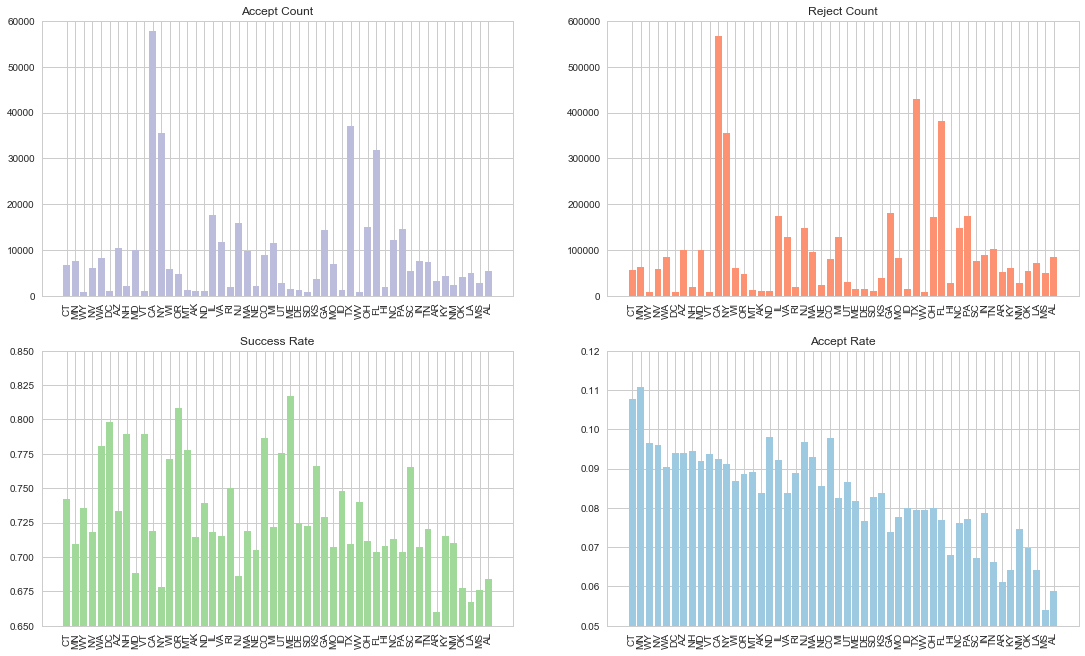

In [253]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
def add_subplot(factor, subplot,ylim, color):
    plt.subplot(subplot)
    plt.title(factor)
    #state_rate[factor].plot.bar(x='State', y=factor)
    plt.bar(x = state_rate['State'], height = state_rate[factor], color=color)
    plt.ylim(ylim)
    plt.xticks(rotation=90)
fig, ax = plt.subplots(figsize=(12, 6))
add_subplot('Accept Count', 221,[0,60000], '#bcbddc')
add_subplot('Reject Count', 222, [0,600000], "#fc9272")
add_subplot('Success Rate', 223, [0.65,0.85], '#a1d99b')
add_subplot('Accept Rate', 224, [0.05,0.12], '#9ecae1')

plt.subplots_adjust(top=1.4, bottom=0, left=0, right=1.2)

In [222]:
# Fit linear regression model to check relationship between success_rate and accept_rate
X = state_rate['Success Rate'].to_frame()
y = state_rate['Accept Rate']
succ_to_accept = LinearRegression().fit(X.values, y.values)

# Consider the distance between estimated accept rate and true rate as bias
state_rate['BIAS'] = pd.Series(succ_to_accept.predict(X.values)) - y
state_rate.head()

,State,Success Rate,Accept Count,Reject Count,Accept Rate,BIAS
24,MS,0.675933,2867,50179,0.054047,0.026415
39,SC,0.765104,5492,76138,0.067279,0.014435
1,AL,0.683806,5329,85421,0.058722,0.029344
16,KY,0.71493,4225,61485,0.064298,0.016738
41,TN,0.720334,7272,102583,0.066196,0.015624


correlation: 0.419442
p-value:     0.002429


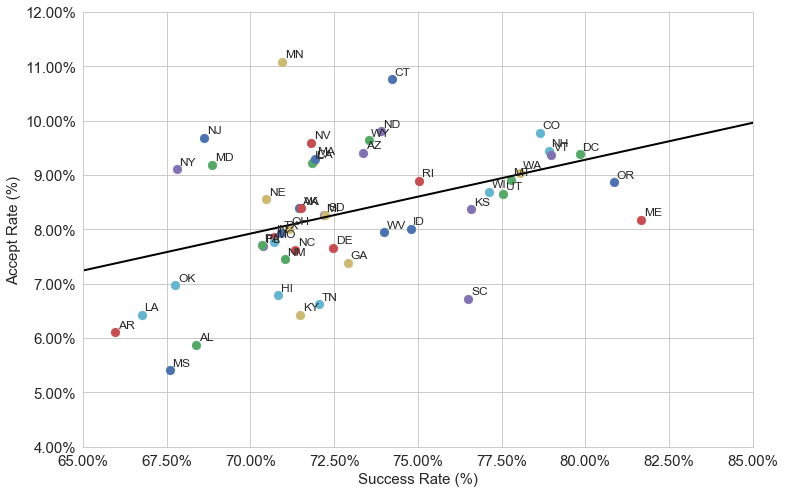

In [170]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(state_rate['Success Rate'], state_rate['Accept Rate'])
print('correlation: %f' % correlation)
print('p-value:     %f' % p_value)

###

values = pd.Series(np.arange(0, 8, 0.01)).to_frame()

prediction = succ_to_accept.predict(values.values)
trend_line = pd.DataFrame({'Success Rate': values[0], 'Accept Rate': prediction})

###

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['Accept Rate'][i]
    plt.scatter(x, y, s=80)
    plt.text(x+0.0008, y+0.0008, state_rate['State'][i], fontsize=12)
trend_line.plot.line(x='Success Rate', y='Accept Rate', ax=ax, color='k', linewidth=2)

ax.set_xlim([0.65, 0.85])
ax.set_ylim([0.04, 0.12])

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels(['{:3.2f}%'.format(k*100) for k in x_ticks])
ax.set_yticklabels(['{:3.2f}%'.format(k*100) for k in y_ticks])
ax.set_ylabel('Accept Rate (%)')
ax.set_xlabel('Success Rate (%)')
ax.legend_.remove()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

Text(0.5,0,'State')

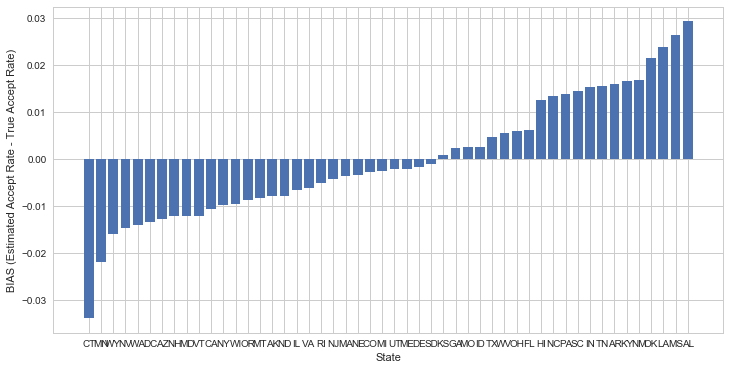

In [225]:
state_rate = state_rate.sort_values(by = 'BIAS')
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x = state_rate['State'], height = state_rate['BIAS'])
#plt.xticks(rotation=30)
y_ticks = ax.get_yticks()
ax.set_ylabel('BIAS (Estimated Accept Rate - True Accept Rate)')
ax.set_xlabel('State')

In [227]:
# The proportion of number of total loans for each state
p_all = df['State'].value_counts()/len(df)
p_all_df = pd.DataFrame({'State': p_all.index, 'All_Prop': p_all.values})
# The proportion of number of rejected loans for every state
p_rej = rej['State'].value_counts()/len(rej)
p_rej_df = pd.DataFrame({'State': p_rej.index, 'Rej_Prop': p_rej.values})

In [228]:
state_prop = pd.merge(p_all_df, p_rej_df, how='left', on=['State'])
state_prop['Diff_Prop'] = state_prop['Rej_Prop'] - state_prop['All_Prop']
state_prop['Diff_num'] = state_prop['Diff_Prop']*len(rej)

Text(0.5,1,'Difference Between Actual and Expect Number of Rejects')

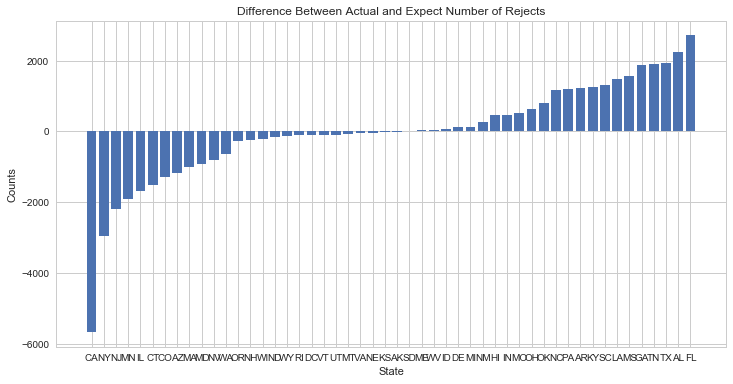

In [229]:
state_prop = state_prop.sort_values(by = 'Diff_num')
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x = state_prop['State'], height = state_prop['Diff_num'])

#ax.set_ylim([0.9, 0.98])
y_ticks = ax.get_yticks()
#ax.set_yticklabels(['{:3.2f}%'.format(k*100) for k in y_ticks])
ax.set_ylabel('Counts')
ax.set_xlabel('State')
ax.set_title('Difference Between Actual and Expect Number of Rejects')

In [254]:
import plotly.plotly as py

#ploty.tools.set_credentials_file(username='jingyichen', api_key='ithtgZkbeInxasauGeMe')

scl=[[0.0, 'rgb(165,0,38)'], [0.2, 'rgb(244,109,67)'], [0.4, 'rgb(254,224,144)'], 
            [0.6, 'rgb(171,217,233)'], [0.8, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_prop['State'],
        z = state_prop['Diff_num'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Bias(counts)")
        ) ]

layout = dict(
        title = 'Difference Between Actual and Expect Number of Rejects',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='lendingclub-cloropleth-map' )

**This graph shows that applications from areas with darker blue are more likely to be rejected, while applications from areas with darker red are less likely to be accepted, comparing with our estimated rejection number. The dark blue areas are mostly southern states (Florida, Texas, Alabama, Tennessee, etc), and the red areas include California, New York, Massachusetts, and etc. This indicates a general pattern that applicants from states which have worse economic status (e.g. lower median household incomes) are more likely to be rejected than expected, and applicants from states which have better economic status face lower probability of rejection than expected. **

In [242]:
scl=[[0.0, 'rgb(165,0,38)'], [0.2, 'rgb(244,109,67)'], [0.4, 'rgb(254,224,144)'], 
            [0.6, 'rgb(171,217,233)'], [0.8, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_rate['State'],
        z = state_rate['BIAS'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Bias")
        ) ]

layout = dict(
        title = 'Estimated Bias',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='lendingclub-cloropleth-map-2' )